In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import InputLayer, Dense, Layer
import numpy as np
import matplotlib.pyplot as plt
import time

np.random.seed(234)
tf.random.set_seed(234)

In [2]:
class ShiftLayer(Layer):
    """A layer for shifting the input by pre-defined domain bounds t_min, t_max"""
    def __init__(self, t_min, t_max):
        super().__init__()
        self.t_min = t_min
        self.t_max = t_max

    def call(self, inputs):
        return 2.0 * (inputs - self.t_min) / (self.t_max - self.t_min) - 1.0


class NeuralNet:
    # Initialize the class
    def __init__(self, t_train, x_train, t_test, x_test, layers, t_min, t_max):
        self.t_train = t_train
        self.x_train = x_train
        self.t_test = t_test
        self.x_test = x_test
        self.loss_history = {"train": [], "test": []}
        
        # Initialize NNs with given number of layers and domain bounds [t_min, tmax]
        self.net = self.create_mlp(t_min, t_max, layers)
    
    @tf.function
    def loss_train(self):
        x_pred = self.net(self.t_train)
        loss = tf.reduce_mean(tf.square(self.x_train - x_pred)) * 10
        return loss
    
    @tf.function
    def loss_test(self):
        x_pred = self.net(self.t_test)
        loss = tf.reduce_mean(tf.square(self.x_test - x_pred)) * 10
        return loss

    def get_test_error(self):
        x_pred = self.net(self.t_test)
        error_x = tf.norm(self.x_test - x_pred, 2) / tf.norm(self.x_test, 2)
        return error_x

    def create_mlp(self, lt, ut, layers):
        """Create the neural net (multilayer perceptron)

        Note:
            Tensorflow provides a convenient programming interface called tf.keras.
            Use tf.keras to create model could save much effort for manually creating/initializing weights .etc.
        """
        model = tf.keras.Sequential()
        model.add(InputLayer(input_shape=(1,), dtype=tf.float32))
        model.add(ShiftLayer(lt, ut))
        model.add(Dense(layers[0], activation=tf.sin, dtype=tf.float32, kernel_initializer="glorot_normal"))
        for n_unit in layers[1:-1]:
            model.add(Dense(n_unit, activation=tf.sin, dtype=tf.float32, kernel_initializer="glorot_normal"))
        model.add(Dense(layers[-1], activation=None, dtype=tf.float32, kernel_initializer="glorot_normal"))
        return model

    def train(self, nIter: int, learning_rate: float, idxOpt: int):
        """Function used for training the model"""
        if idxOpt == 1:
            # mode 1: running the Gradient Descent optimization
            self.optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
        elif idxOpt == 2:
            # mode 2: running the Adam optimization
            self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        else:
            raise ValueError("Unsupported idxOpt")

        varlist = self.net.trainable_variables
        start_time = time.time()

        for it in range(nIter):
            self.optimizer.minimize(self.loss_train, varlist)
            
            # Print
            if it % 100 == 0:
                elapsed = time.time() - start_time
                loss_train = self.loss_train().numpy()
                loss_test = self.loss_test().numpy()
                self.loss_history["train"].append(loss_train)
                self.loss_history["test"].append(loss_test)
                print('It: %d, Train Loss: %.3e, Test Loss: %.3e, Time: %.2f' % 
                      (it, loss_train, loss_test, elapsed))
                start_time = time.time()

In [3]:
%matplotlib inline
def plot(t_all, x_all, pred_all, t_test, x_test, title: str):
    fig = plt.figure(figsize=(21, 24))

    ax = plt.subplot(311)
    ax.plot(t_all, x_all, "r", label="Exact Solution")
    ax.plot(t_all, pred_all, "b--", label="Prediction")
    ax.scatter(t_test, x_test, s=30, c="g", label="Test Data Point")
    ax.legend()
    ax.set_xlabel("$t$", fontsize = 12)
    ax.set_ylabel("$x$", fontsize = 12, rotation = 0)
    ax.set_title("$Fitting$", fontsize = 15)

    ax = plt.subplot(312)
    ax.plot(t_all, pred_all - x_all, "b-")
    ax.set_xlabel("$t$", fontsize = 12)
    ax.set_ylabel("Prediction - Exact Solution", fontsize = 12, rotation = 90)
    ax.set_title("Difference between Prediction and Exact Solution", fontsize = 15)

    ax = plt.subplot(313)
    loss_train = np.array(model.loss_history["train"])
    loss_test = np.array(model.loss_history["test"])
    ax.scatter(np.arange(loss_train.size) * 100, loss_train, s=30, marker="x", label="Train Loss")
    ax.scatter(np.arange(loss_train.size) * 100, loss_test, s=30, marker="+", label="Test Loss")
    ax.legend()
    ax.set_xlabel("$iterations$", fontsize = 12)
    ax.set_ylabel("Loss", fontsize = 12, rotation = 90)
    ax.set_yscale("log")
    ax.set_title('Loss Curve', fontsize = 15)
    
    plt.gcf().text(0.02, 0.9, title, fontsize=20)

It: 0, Train Loss: 5.169e+00, Test Loss: 4.667e+00, Time: 0.87
It: 100, Train Loss: 5.109e+00, Test Loss: 4.562e+00, Time: 0.57
It: 200, Train Loss: 5.065e+00, Test Loss: 4.522e+00, Time: 0.64
It: 300, Train Loss: 3.798e+01, Test Loss: 3.918e+01, Time: 0.64
It: 400, Train Loss: 3.752e-03, Test Loss: 4.897e-03, Time: 0.55
It: 500, Train Loss: 3.542e-04, Test Loss: 4.014e-04, Time: 0.61
It: 600, Train Loss: 3.536e-04, Test Loss: 4.006e-04, Time: 0.62
It: 700, Train Loss: 3.529e-04, Test Loss: 3.998e-04, Time: 0.60
It: 800, Train Loss: 3.523e-04, Test Loss: 3.991e-04, Time: 0.58
It: 900, Train Loss: 3.517e-04, Test Loss: 3.984e-04, Time: 0.53
It: 1000, Train Loss: 3.510e-04, Test Loss: 3.977e-04, Time: 0.53
It: 1100, Train Loss: 3.504e-04, Test Loss: 3.970e-04, Time: 0.53
It: 1200, Train Loss: 3.498e-04, Test Loss: 3.963e-04, Time: 0.54
It: 1300, Train Loss: 3.492e-04, Test Loss: 3.956e-04, Time: 0.54
It: 1400, Train Loss: 3.486e-04, Test Loss: 3.949e-04, Time: 0.55
It: 1500, Train Loss: 

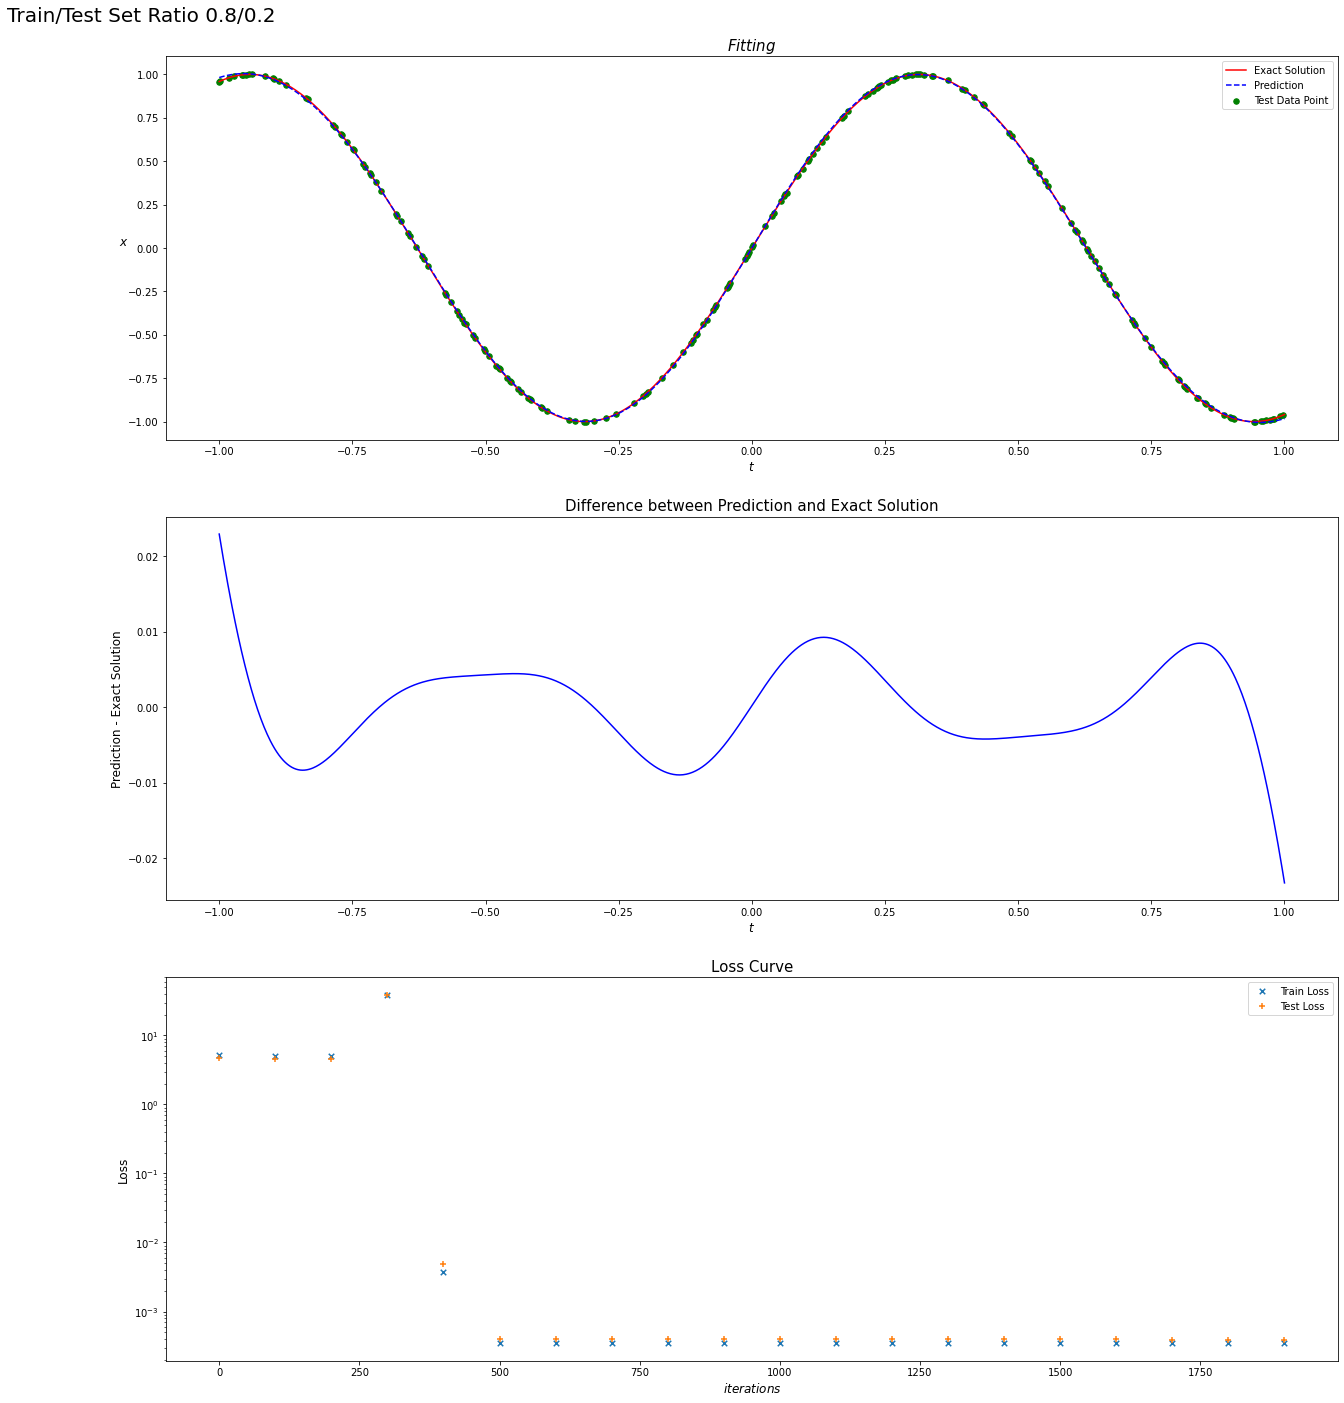

In [4]:
# Create data points and get random split of train, test data sets by index slicing
n_total = 1000
train_ratio = 0.8
n_train = int(n_total * train_ratio)

t_all = np.linspace(-1, 1, n_total)
x_all = np.sin(5 * t_all)

train_indices = np.zeros(t_all.size, dtype=bool)
train_indices[:n_train] = True
np.random.shuffle(train_indices)

t_train = t_all[train_indices]
x_train = x_all[train_indices]
t_train = tf.reshape(tf.cast(t_train, dtype = tf.float32), shape=(-1, 1))
x_train = tf.reshape(tf.cast(x_train, dtype = tf.float32), shape=(-1, 1))

t_test = t_all[~train_indices]
x_test = x_all[~train_indices]
t_test = tf.reshape(tf.cast(t_test, dtype = tf.float32), shape=(-1, 1))
x_test = tf.reshape(tf.cast(x_test, dtype = tf.float32), shape=(-1, 1))

model = NeuralNet(
    t_train=t_train, x_train=x_train, t_test=t_test, x_test=x_test,
    layers=[100, 100, 100, 1], t_min=t_all.min(0), t_max=t_all.max(0))

start_time = time.time()
model.train(2000, learning_rate=0.01, idxOpt=1)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

pred_all = model.net(tf.reshape(tf.cast(t_all, dtype=tf.float32), shape=(-1, 1))).numpy().flatten()
print('Norm of Differnece: %e' % (model.get_test_error().numpy()))

plot(t_all, x_all, pred_all, t_test, x_test, title="Train/Test Set Ratio 0.8/0.2")

It: 0, Train Loss: 4.989e+00, Test Loss: 5.108e+00, Time: 0.17
It: 100, Train Loss: 4.954e+00, Test Loss: 5.062e+00, Time: 0.57
It: 200, Train Loss: 4.945e+00, Test Loss: 5.053e+00, Time: 0.56
It: 300, Train Loss: 4.927e+00, Test Loss: 5.036e+00, Time: 0.57
It: 400, Train Loss: 4.710e+00, Test Loss: 4.835e+00, Time: 0.57
It: 500, Train Loss: 4.964e+00, Test Loss: 5.069e+00, Time: 0.58
It: 600, Train Loss: 4.954e+00, Test Loss: 5.058e+00, Time: 0.55
It: 700, Train Loss: 4.928e+00, Test Loss: 5.030e+00, Time: 0.52
It: 800, Train Loss: 1.050e+00, Test Loss: 1.125e+00, Time: 0.58
It: 900, Train Loss: 2.555e-02, Test Loss: 2.978e-02, Time: 0.68
It: 1000, Train Loss: 9.365e-03, Test Loss: 1.049e-02, Time: 0.71
It: 1100, Train Loss: 6.687e-03, Test Loss: 7.349e-03, Time: 0.61
It: 1200, Train Loss: 5.180e-03, Test Loss: 5.616e-03, Time: 0.59
It: 1300, Train Loss: 4.224e-03, Test Loss: 4.535e-03, Time: 0.61
It: 1400, Train Loss: 3.569e-03, Test Loss: 3.803e-03, Time: 0.58
It: 1500, Train Loss: 

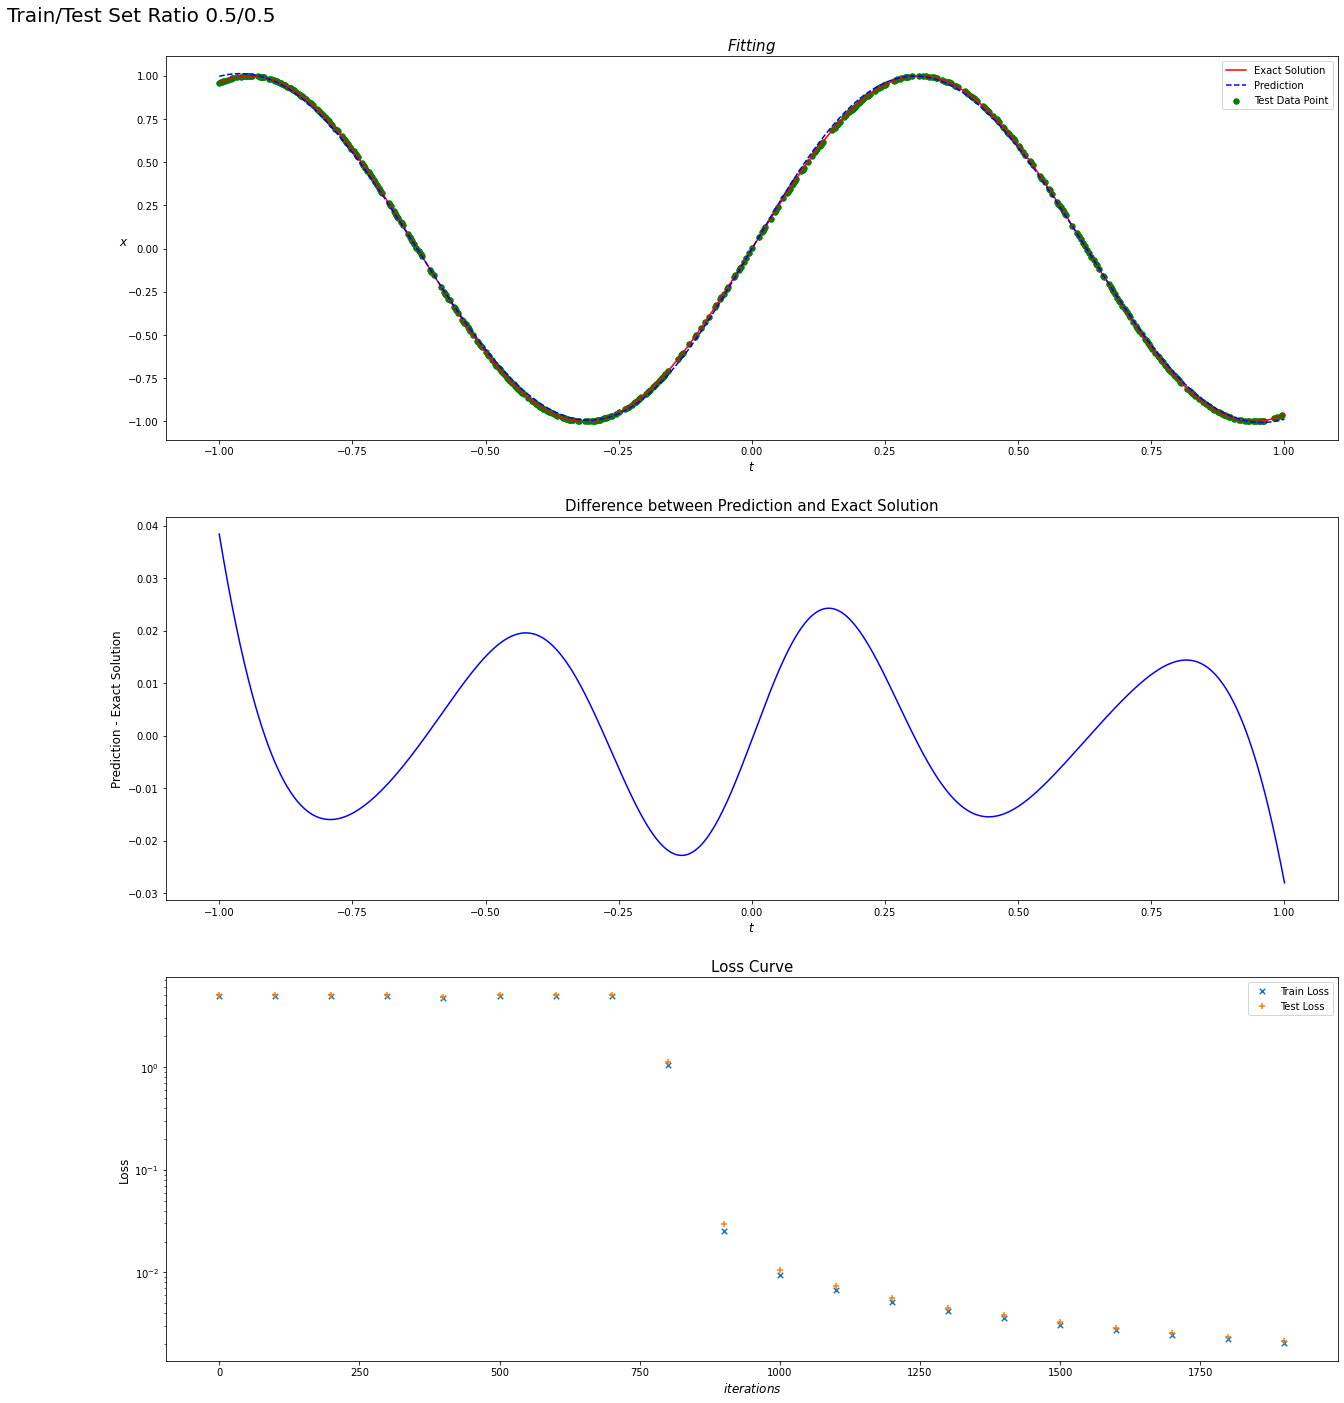

In [5]:
# Create data points and get random split of train, test data sets by index slicing
n_total = 1000
train_ratio = 0.5
n_train = int(n_total * train_ratio)

t_all = np.linspace(-1, 1, n_total)
x_all = np.sin(5 * t_all)

train_indices = np.zeros(t_all.size, dtype=bool)
train_indices[:n_train] = True
np.random.shuffle(train_indices)

t_train = t_all[train_indices]
x_train = x_all[train_indices]
t_train = tf.reshape(tf.cast(t_train, dtype = tf.float32), shape=(-1, 1))
x_train = tf.reshape(tf.cast(x_train, dtype = tf.float32), shape=(-1, 1))

t_test = t_all[~train_indices]
x_test = x_all[~train_indices]
t_test = tf.reshape(tf.cast(t_test, dtype = tf.float32), shape=(-1, 1))
x_test = tf.reshape(tf.cast(x_test, dtype = tf.float32), shape=(-1, 1))

model = NeuralNet(
    t_train=t_train, x_train=x_train, t_test=t_test, x_test=x_test,
    layers=[100, 100, 100, 1], t_min=t_all.min(0), t_max=t_all.max(0))

start_time = time.time()
model.train(2000, learning_rate=0.01, idxOpt=1)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

pred_all = model.net(tf.reshape(tf.cast(t_all, dtype=tf.float32), shape=(-1, 1))).numpy().flatten()
print('Norm of Differnece: %e' % (model.get_test_error().numpy()))

plot(t_all, x_all, pred_all, t_test, x_test, title="Train/Test Set Ratio 0.5/0.5")

It: 0, Train Loss: 4.530e+00, Test Loss: 5.238e+00, Time: 0.33
It: 100, Train Loss: 4.514e+00, Test Loss: 5.157e+00, Time: 0.66
It: 200, Train Loss: 4.501e+00, Test Loss: 5.144e+00, Time: 0.71
It: 300, Train Loss: 4.264e+00, Test Loss: 4.887e+00, Time: 0.63
It: 400, Train Loss: 3.692e-03, Test Loss: 4.899e-03, Time: 0.59
It: 500, Train Loss: 3.047e-03, Test Loss: 4.052e-03, Time: 0.61
It: 600, Train Loss: 2.857e-03, Test Loss: 3.821e-03, Time: 0.59
It: 700, Train Loss: 2.696e-03, Test Loss: 3.622e-03, Time: 0.59
It: 800, Train Loss: 2.556e-03, Test Loss: 3.448e-03, Time: 0.59
It: 900, Train Loss: 2.433e-03, Test Loss: 3.294e-03, Time: 0.58
It: 1000, Train Loss: 2.324e-03, Test Loss: 3.157e-03, Time: 0.61
It: 1100, Train Loss: 2.228e-03, Test Loss: 3.034e-03, Time: 0.62
It: 1200, Train Loss: 2.141e-03, Test Loss: 2.923e-03, Time: 0.59
It: 1300, Train Loss: 2.062e-03, Test Loss: 2.822e-03, Time: 0.59
It: 1400, Train Loss: 1.990e-03, Test Loss: 2.730e-03, Time: 0.58
It: 1500, Train Loss: 

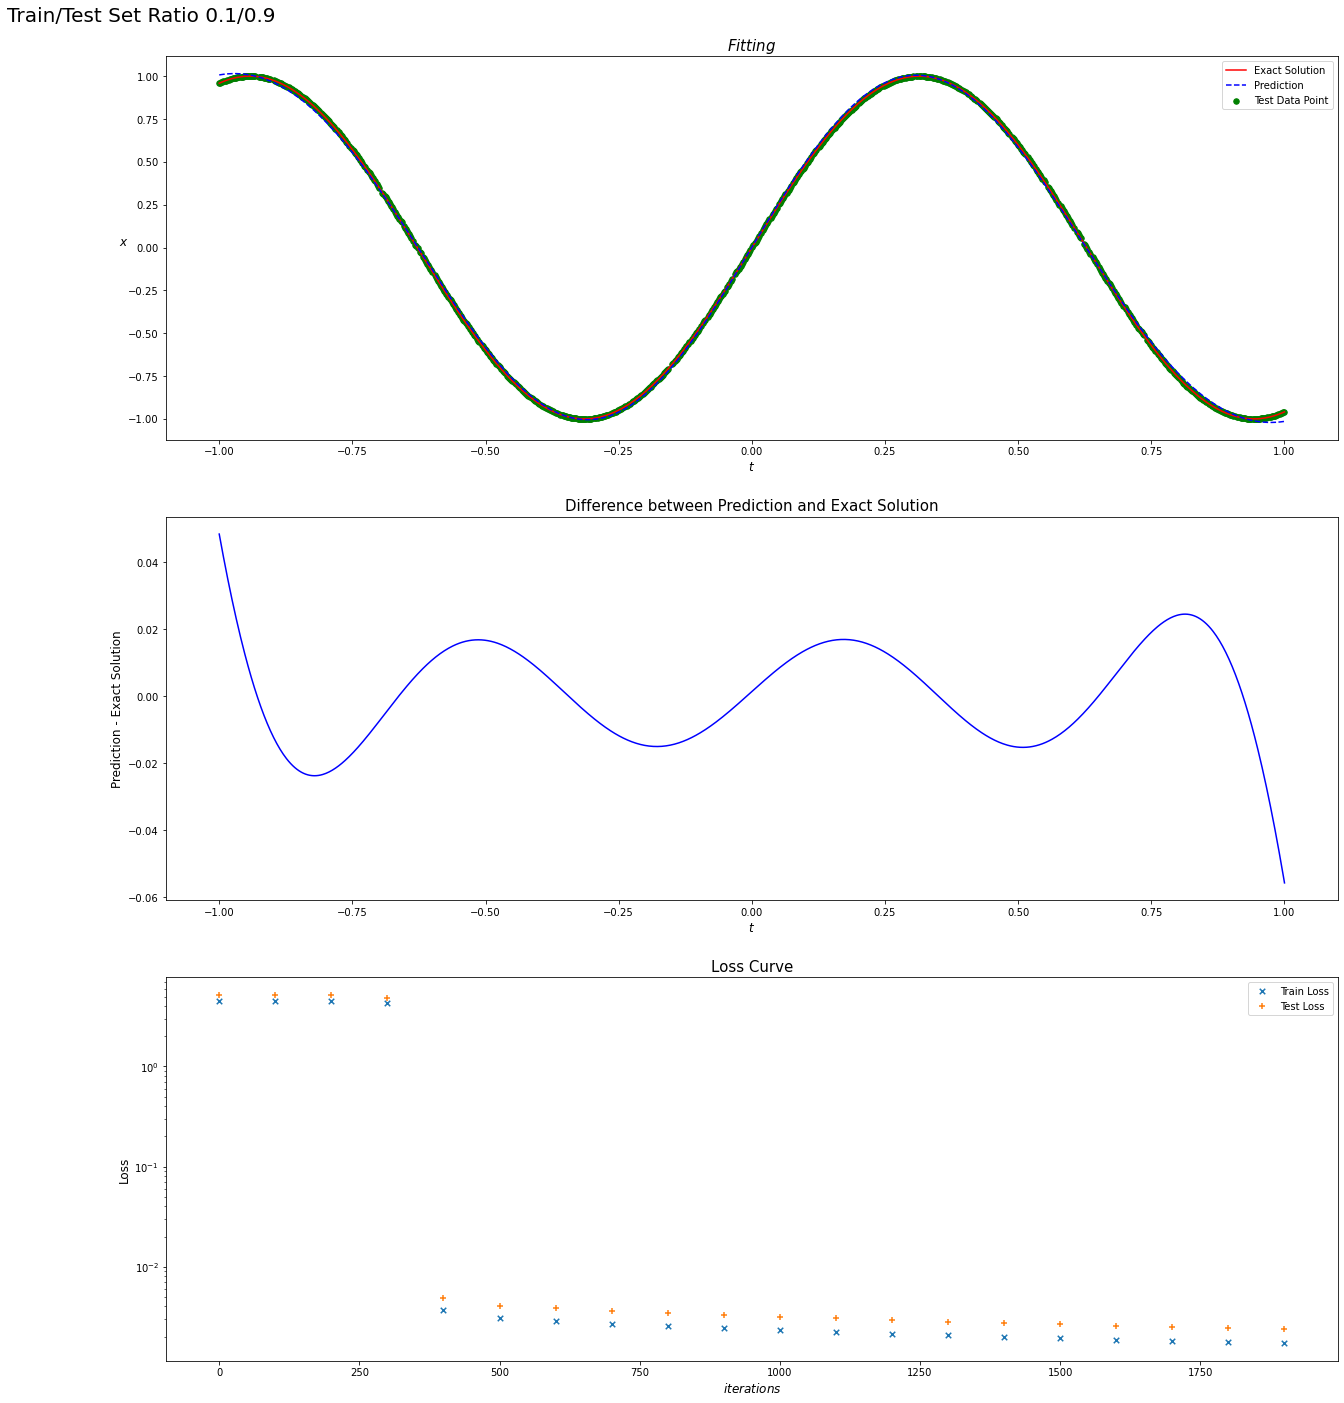

In [6]:
# Create data points and get random split of train, test data sets by index slicing
n_total = 1000
train_ratio = 0.1
n_train = int(n_total * train_ratio)

t_all = np.linspace(-1, 1, n_total)
x_all = np.sin(5 * t_all)

train_indices = np.zeros(t_all.size, dtype=bool)
train_indices[:n_train] = True
np.random.shuffle(train_indices)

t_train = t_all[train_indices]
x_train = x_all[train_indices]
t_train = tf.reshape(tf.cast(t_train, dtype = tf.float32), shape=(-1, 1))
x_train = tf.reshape(tf.cast(x_train, dtype = tf.float32), shape=(-1, 1))

t_test = t_all[~train_indices]
x_test = x_all[~train_indices]
t_test = tf.reshape(tf.cast(t_test, dtype = tf.float32), shape=(-1, 1))
x_test = tf.reshape(tf.cast(x_test, dtype = tf.float32), shape=(-1, 1))

model = NeuralNet(
    t_train=t_train, x_train=x_train, t_test=t_test, x_test=x_test,
    layers=[100, 100, 100, 1], t_min=t_all.min(0), t_max=t_all.max(0))

start_time = time.time()
model.train(2000, learning_rate=0.01, idxOpt=1)
elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))

pred_all = model.net(tf.reshape(tf.cast(t_all, dtype=tf.float32), shape=(-1, 1))).numpy().flatten()
print('Norm of Differnece: %e' % (model.get_test_error().numpy()))

plot(t_all, x_all, pred_all, t_test, x_test, title="Train/Test Set Ratio 0.1/0.9")